In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        return conn.execute(c)

def show_tables():
    query = '''SELECT 
                    name, 
                    type 
               FROM sqlite_master 
               WHERE type IN ("table","view");'''
    return run_query(query)
        

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [26]:
q1 = '''
        SELECT 
            g.name genre,
            COUNT(il.invoice_line_id) tracks_sold_number
        FROM genre g
        INNER JOIN track t ON g.genre_id = t.genre_id
        INNER JOIN invoice_line il ON t.genre_id = il.track_id
        GROUP BY 1
        ORDER BY 2 DESC;
     '''
q1_df = run_query(q1)
q1_df

,genre,tracks_sold_number
0,Rock,10376
1,Latin,2316
2,Alternative & Punk,1328
3,Blues,1053
4,TV Shows,558
5,Drama,448
6,Classical,444
7,Pop,432
8,Jazz,390
9,Metal,374


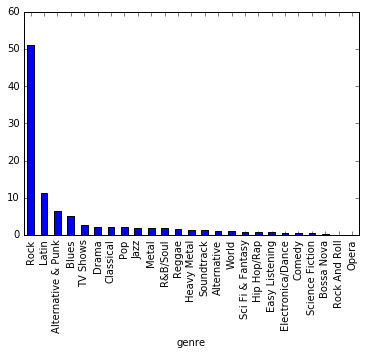

In [27]:
q1_df.set_index("genre", inplace=True, drop=True)
q1_df["tracks_sold_percent"] = q1_df["tracks_sold_number"] / sum(q1_df["tracks_sold_number"]) * 100
q1_df["tracks_sold_percent"].plot.bar()

In [5]:
q2 = '''
        SELECT
            e.first_name || " " || e.last_name employee_name,
            e.title,
            e.country,
            e.state,
            e.city,
            e.hire_date,
            SUM(i.total) total_sold
        FROM employee e
        INNER JOIN customer c ON e.employee_id = c.support_rep_id
        INNER JOIN invoice i ON c.customer_id = i.customer_id
        GROUP BY 1
        ORDER BY 7 DESC;
     '''

q2_df = run_query(q2)
q2_df

,employee_name,title,country,state,city,hire_date,total_sold
0,Jane Peacock,Sales Support Agent,Canada,AB,Calgary,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,Canada,AB,Calgary,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,Canada,AB,Calgary,2017-10-17 00:00:00,1393.92


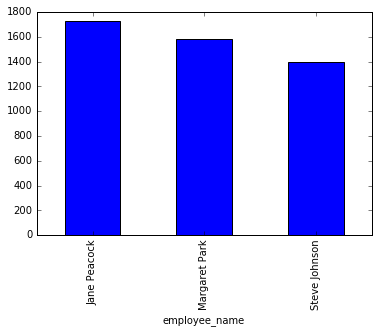

In [6]:
q2_df.set_index("employee_name", inplace=True, drop=True)
q2_df["total_sold"].plot.bar()

(736420.0, 736619.0)

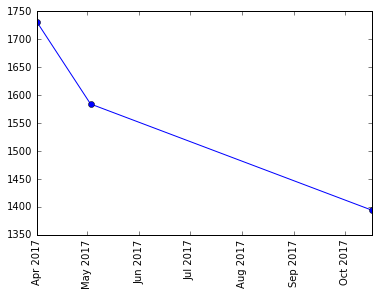

In [7]:
q2_df["hire_date"] = pd.to_datetime(q2_df["hire_date"])
plt.plot(q2_df["hire_date"], q2_df["total_sold"], "-o")
plt.xticks(rotation = 90)
plt.xlim()

In [22]:
q3 = '''
        SELECT
            c.country,
            COUNT(c.customer_id) total_customers,
            SUM(i.total) total_sales,
            CAST(SUM(i.total) as float) / CAST(COUNT(c.customer_id) as float) average_sales_per_customer
        FROM customer c
        INNER JOIN invoice i ON c.customer_id = i.customer_id
        GROUP BY 1
        ORDER BY 1;
    '''

q3_df = run_query(q3)

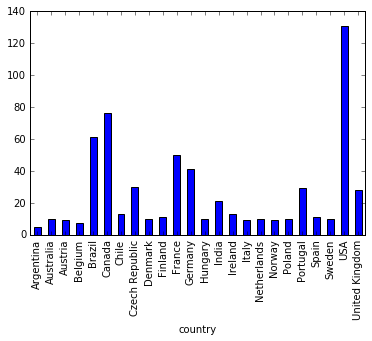

In [23]:
q3_df = q3_df.set_index("country")
q3_df["total_customers"].plot.bar()

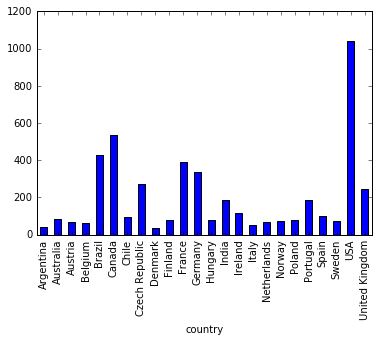

In [24]:
q3_df["total_sales"].plot.bar()

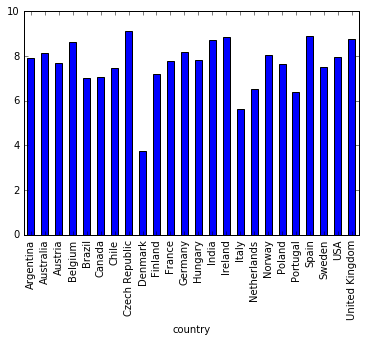

In [25]:
q3_df["average_sales_per_customer"].plot.bar()

In [31]:
q4 = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                                     
                  EXCEPT 
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase
'''

In [32]:
run_query(q4)

,album_purchase,number_of_invoices,percent
0,no,497,0.809446
1,yes,117,0.190554


In [33]:
q5 = '''
WITH invoice_first_track AS 
    (
     SELECT
         il.invoice_id invoice_id,
         i.customer_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     GROUP BY 1, 2
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                       ) percent
FROM
    (
    SELECT
        ifs.*,
        t.album_id,
        CASE
            WHEN
                (
                 SELECT t3.track_id FROM track t3
                 WHERE t3.album_id = t.album_id
                 
                 EXCEPT
                 
                 SELECT il2.track_id FROM invoice_line il2
                 INNER JOIN invoice i2 ON i2.invoice_id = il2.invoice_id
                 INNER JOIN track t2 ON t2.track_id = il2.track_id
                 WHERE
                         il2.invoice_id <= ifs.invoice_id
                     AND i2.customer_id = ifs.customer_id
                     AND t2.album_id = t.album_id

                ) IS NULL THEN "yes"
            ELSE "no"
        END AS "album_purchase"
    FROM invoice_first_track ifs
    INNER JOIN track t ON ifs.first_track_id = t.track_id
    )
GROUP BY 1
'''


In [34]:
run_query(q5)

,album_purchase,number_of_invoices,percent
0,no,475,0.773616
1,yes,139,0.226384
